## Demo of the Swiss Data Cube <a name="top"></a>

This notebook introduces you to the Swis Data Cube. It has the following sections:

- **[Standard script/notebook beginning](#standbeg)**: To run cells from other sections you first need to run all cells of this section.

- **[Load a data cube](#loaddcoptb)**: loads a datacube (into an `xarray.Dataset`) for further analysis.
    
- **[Explore created data cube](#explorexr)**: explore the created `xarray.Dataset` variable (dataset_clean).

- **[Create, plot and export mosaic figure using default data cube functions](#pngdef)**

- **[Plot and export mosaic figure using Swiss Data Cube functions](#pngsdc)**

- **[Export `xarray.Dataset`](#exportds)**

- **[Create, plot and export `xarray.DataArray`](#dataarray)**

- **[Water time series analysis](#waterts)**
    

---


### Standard script beginning <a name="standbeg"></a>

The cells in this section are generally found at the beginning of a script (and it is advised to apply this template).

To run cells from above sections you need to run all cells of this section.

- **import dependencies**: import libraries, connect to datacube.
- **Configuration**: all variables you might need to change. Keep in mind that the larger it will be (in terms of geograhical extent, time period and number of measurements (bands)), the slower the loading will go.
- **Functions**: all functions written in-script
[<div style="text-align: right; font-size: 24px"> &#x1F51D; </div>](#top)

In [1]:
# Make sure the script is using the correct kernel (see also the README)
try:
    %run ../swiss_utils/assert_env.py
except:
    %run ./swiss_utils/assert_env.py

In [2]:
# Import modules

# reload module before executing code
%load_ext autoreload
%autoreload 2

# define modules locations (you might have to adapt define_mod_locs.py)
%run ../swiss_utils/define_mod_locs.py

# to plot figures
%matplotlib inline

# import full general libraries

# import general libraries and allocate them a specific name
import numpy as np # np.average
import pandas as pd # DataFrame
import matplotlib.pyplot as plt

# import specific functions from general libraries
from datetime import datetime
from IPython.display import Image, display, HTML
from matplotlib import colors

# import dedicated function of general libraries

# import ODC (default) functions
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
from utils.data_cube_utilities.dc_utilities import write_png_from_xr
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

# import SDC functions
from swiss_utils.data_cube_utilities.sdc_utilities import ls_qa_clean, load_multi_clean, \
                                                          write_geotiff_from_xr, time_list
from swiss_utils.data_cube_utilities.sdc_advutils import oneband_fig, composite_fig

# connect to DC
import datacube
dc = datacube.Datacube()

# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")

### Set up the data cube
The next cell contains the data cube configuration information:

- product
- geographical extent
- time period
- bands

You can generate it in three ways:
1. manually from scratch,
2. by manually copy/pasting the final cell content of the [config_tool](config_tool.ipynb) notebook,
3. by loading the final cell content of the [config_tool](config_tool.ipynb) notebook using the magic `%load config_cell.txt`.

Apply the following rules when generating the configuration cell:
- select a **small dataset** (geograhical extent, time period and number of measurements (bands)) for faster processing,
- select an **area covering only a small parts of mountains** (as snow is generally confused with clouds and then considered as nodata),
- for the previous reason, **avoid to select winter period**.

Specifically for this demo:
- Use **landsat, but not Landsat 7 product** (as it contains large part of nodata since 2003),
- **The following measurements are required**: `red, green, blue, nir, swir1, swir2` and `pixel_qa`
- the geographical extent should contain some surface with a water body as water detection tools will be used.

In [3]:
# %load config_cell.txt
# Configuration

product = 'ls8_lasrc_swiss'
measurements = ['blue', 'green', 'red', 'pixel_qa', 'nir', 'swir1', 'swir2']

min_lon = 7.109528
max_lon = 7.189178
min_lat = 46.795359
max_lat = 46.851974

start_date = datetime.strptime('2021-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2021-12-30', '%Y-%m-%d')


### Load data cube<a name="loaddcoptb"></a>

Load requested data cube (meaning an [xarray.Dataset](http://xarray.pydata.org/en/stable/index.html) variable will be created) based on configuration parameters, using [load_multi_clean](demo_FUN_load_multi_clean.ipynb).

This function loads several products (in the same xarray.Dataset), cleans it and generates a mask.

Various masking functions are available from the Open Data Cube libraries and the SDC, each one giving slightly different results. The function `load_multi_clean`:

- can process Landsat as well as **Sentinel 2** data cubes
- with Landsat, gives **priority to snow** when there is a low probability of cloud cover
- can load **several products** at once.

**load_multi_clean** generates two outputs:

- a clean `xarray.Dataset`
- a boolean mask `numpy.ndarray`

Documentation for a given function can be accessed simply by adding ? at the end of the function in a cell. e.g. `load_multi_clean?` or by selecting the function and pressing `Shift-Tab`.
[<div style="text-align: right; font-size: 24px"> &#x1F51D; </div>](#top)

In [4]:
# Load a cube using SDC load_multi_clean function which will generate a clean dataset
# Sometimes this doesn't work the first time - if not, re-execute the %load config_cell.txt cell then try again!

dataset_clean, clean_mask = load_multi_clean(dc = dc,
                                             products = product ,
                                             time = [start_date, end_date],
                                             lon = (min_lon, max_lon),
                                             lat = (min_lat, max_lat),
                                             measurements = measurements 
                                             )

In [5]:
# Let's take a look at the contents of the datacube we've loaded
dataset_clean

<xarray.Dataset>
Dimensions:      (time: 31, latitude: 167, longitude: 235)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-09T10:22:54 ... 2021-10-24T10:...
  * latitude     (latitude) float64 46.85 46.85 46.85 46.85 ... 46.8 46.8 46.8
  * longitude    (longitude) float64 7.109 7.11 7.11 7.11 ... 7.188 7.189 7.189
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) float64 7.229e+03 ... 223.0
    green        (time, latitude, longitude) float64 7.413e+03 ... 571.0
    red          (time, latitude, longitude) float64 7.735e+03 ... 455.0
    pixel_qa     (time, latitude, longitude) float64 336.0 336.0 ... 322.0 322.0
    nir          (time, latitude, longitude) float64 7.601e+03 ... 3.594e+03
    swir1        (time, latitude, longitude) float64 641.0 648.0 ... 2.1e+03
    swir2        (time, latitude, longitude) float64 716.0 729.0 ... 1.288e+03
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

(array([8.180000e+02, 1.011646e+06, 1.039800e+04, 1.916000e+03,
        1.275000e+03, 3.870000e+02, 8.000000e+00, 1.000000e+00,
        1.000000e+00, 5.000000e+00]),
 array([-1940.,  -146.,  1648.,  3442.,  5236.,  7030.,  8824., 10618.,
        12412., 14206., 16000.]),
 <BarContainer object of 10 artists>)

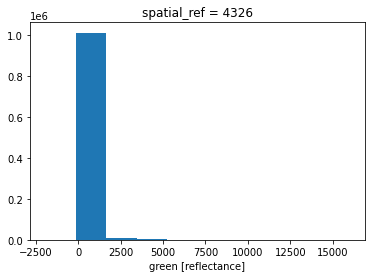

In [6]:
# let's plot an histogram of green band
dataset_clean.green.plot.hist()

### Explore the created xarray.Dataset variable (dataset_clean) <a name="explorexr"></a>
[<div style="text-align: right; font-size: 24px"> &#x1F51D; </div>](#top)

In [7]:
# Look at dimensions
dataset_clean.dims

Frozen({'time': 31, 'latitude': 167, 'longitude': 235})

In [8]:
# get the number of time points in the cube
print('time count: %s\n' % (len(dataset_clean.time)))

time count: 31



In [9]:
# Look at time dimension
dataset_clean.time

<xarray.DataArray 'time' (time: 31)>
array(['2021-01-09T10:22:54.000000000', '2021-01-18T10:17:03.000000000',
       '2021-02-19T10:16:33.000000000', '2021-02-19T10:16:57.000000000',
       '2021-02-26T10:22:41.000000000', '2021-03-07T10:16:26.000000000',
       '2021-03-07T10:16:50.000000000', '2021-03-23T10:16:19.000000000',
       '2021-03-23T10:16:42.000000000', '2021-03-30T10:22:28.000000000',
       '2021-04-08T10:16:14.000000000', '2021-04-08T10:16:38.000000000',
       '2021-04-15T10:22:22.000000000', '2021-04-24T10:16:07.000000000',
       '2021-04-24T10:16:31.000000000', '2021-06-18T10:22:32.000000000',
       '2021-07-20T10:22:38.000000000', '2021-07-29T10:16:32.000000000',
       '2021-07-29T10:16:56.000000000', '2021-08-14T10:16:38.000000000',
       '2021-08-14T10:17:02.000000000', '2021-08-21T10:22:51.000000000',
       '2021-08-30T10:16:43.000000000', '2021-08-30T10:17:07.000000000',
       '2021-09-06T10:22:56.000000000', '2021-10-01T10:16:52.000000000',
       '2021-10-01T10:17:16.000000000', '2021-10-08T10:23:05.000000000',
       '2021-10-17T10:16:56.000000000', '2021-10-17T10:17:20.000000000',
       '2021-10-24T10:23:07.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-01-09T10:22:54 ... 2021-10-24T10:...
    spatial_ref  int32 4326
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [10]:
# nicely display time values using pandas library
pd.DataFrame(dataset_clean.time, columns=['date'])

date
0  2021-01-09 10:22:54
1  2021-01-18 10:17:03
2  2021-02-19 10:16:33
3  2021-02-19 10:16:57
4  2021-02-26 10:22:41
5  2021-03-07 10:16:26
6  2021-03-07 10:16:50
7  2021-03-23 10:16:19
8  2021-03-23 10:16:42
9  2021-03-30 10:22:28
10 2021-04-08 10:16:14
11 2021-04-08 10:16:38
12 2021-04-15 10:22:22
13 2021-04-24 10:16:07
14 2021-04-24 10:16:31
15 2021-06-18 10:22:32
16 2021-07-20 10:22:38
17 2021-07-29 10:16:32
18 2021-07-29 10:16:56
19 2021-08-14 10:16:38
20 2021-08-14 10:17:02
21 2021-08-21 10:22:51
22 2021-08-30 10:16:43
23 2021-08-30 10:17:07
24 2021-09-06 10:22:56
25 2021-10-01 10:16:52
26 2021-10-01 10:17:16
27 2021-10-08 10:23:05
28 2021-10-17 10:16:56
29 2021-10-17 10:17:20
30 2021-10-24 10:23:07

In [11]:
# visualize specific red band
# an xarray.Dataset variable consists in an xarray.DataArray
dataset_clean.red

<xarray.DataArray 'red' (time: 31, latitude: 167, longitude: 235)>
array([[[7735., 7718., 7555., ...,   nan,   nan,   nan],
        [7627., 7583., 7591., ...,   nan,   nan,   nan],
        [7703., 7623., 7486., ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[4025., 4021., 3987., ..., 1130., 1404., 1748.],
        [4059., 4206., 4161., ..., 1807., 1786., 1444.],
        [4374., 4214., 3990., ..., 2093., 1799., 1413.],
        ...,
        [ 561.,  561.,  363., ..., 1474., 1474., 3708.],
        [ 431.,  745.,  831., ..., 5498., 5498., 5400.],
        [ 443.,  643., 1304., ..., 4878., 4878., 4887.]],

       [[1005.,  914.,  871., ...,  646., 1429., 1131.],
        [ 887.,  882.,  833., ...,  846.,  891.,  997.],
        [ 832.,  787.,  740., ..., 1009.,  686.,  962.],
        ...,
...
        ...,
        [ 382.,  382.,  418., ...,  490.,  490.,  642.],
        [ 466.,  611.,  540., ...,  467.,  467.,  437.],
        [ 703.,  759.,  641., ...,  377.,  377.,  442.]],

       [[1743., 1696., 1602., ...,  371., 1181.,  926.],
        [1918., 1729., 1569., ...,  718.,  654.,  654.],
        [2049., 1656., 1479., ...,  773.,  452.,  579.],
        ...,
        [ 341.,  341.,  370., ...,  438.,  438.,  597.],
        [ 436.,  551.,  476., ...,  434.,  434.,  401.],
        [ 647.,  740.,  563., ...,  345.,  345.,  426.]],

       [[1142., 1358., 1437., ...,  532., 1181., 1176.],
        [1407., 1428., 1381., ...,  885.,  767.,  881.],
        [1432., 1405., 1360., ...,  855.,  693.,  664.],
        ...,
        [ 511.,  511.,  490., ...,  453.,  453.,  669.],
        [ 520.,  657.,  534., ...,  493.,  493.,  432.],
        [ 637.,  665.,  598., ...,  365.,  365.,  455.]]])
Coordinates:
  * time         (time) datetime64[ns] 2021-01-09T10:22:54 ... 2021-10-24T10:...
  * latitude     (latitude) float64 46.85 46.85 46.85 46.85 ... 46.8 46.8 46.8
  * longitude    (longitude) float64 7.109 7.11 7.11 7.11 ... 7.188 7.189 7.189
    spatial_ref  int32 4326
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [12]:
# visualize specific red band for a given time index
# remember in Python indexing starts at 0
dataset_clean.red.isel(time=0)

<xarray.DataArray 'red' (latitude: 167, longitude: 235)>
array([[7735., 7718., 7555., ...,   nan,   nan,   nan],
       [7627., 7583., 7591., ...,   nan,   nan,   nan],
       [7703., 7623., 7486., ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])
Coordinates:
    time         datetime64[ns] 2021-01-09T10:22:54
  * latitude     (latitude) float64 46.85 46.85 46.85 46.85 ... 46.8 46.8 46.8
  * longitude    (longitude) float64 7.109 7.11 7.11 7.11 ... 7.188 7.189 7.189
    spatial_ref  int32 4326
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

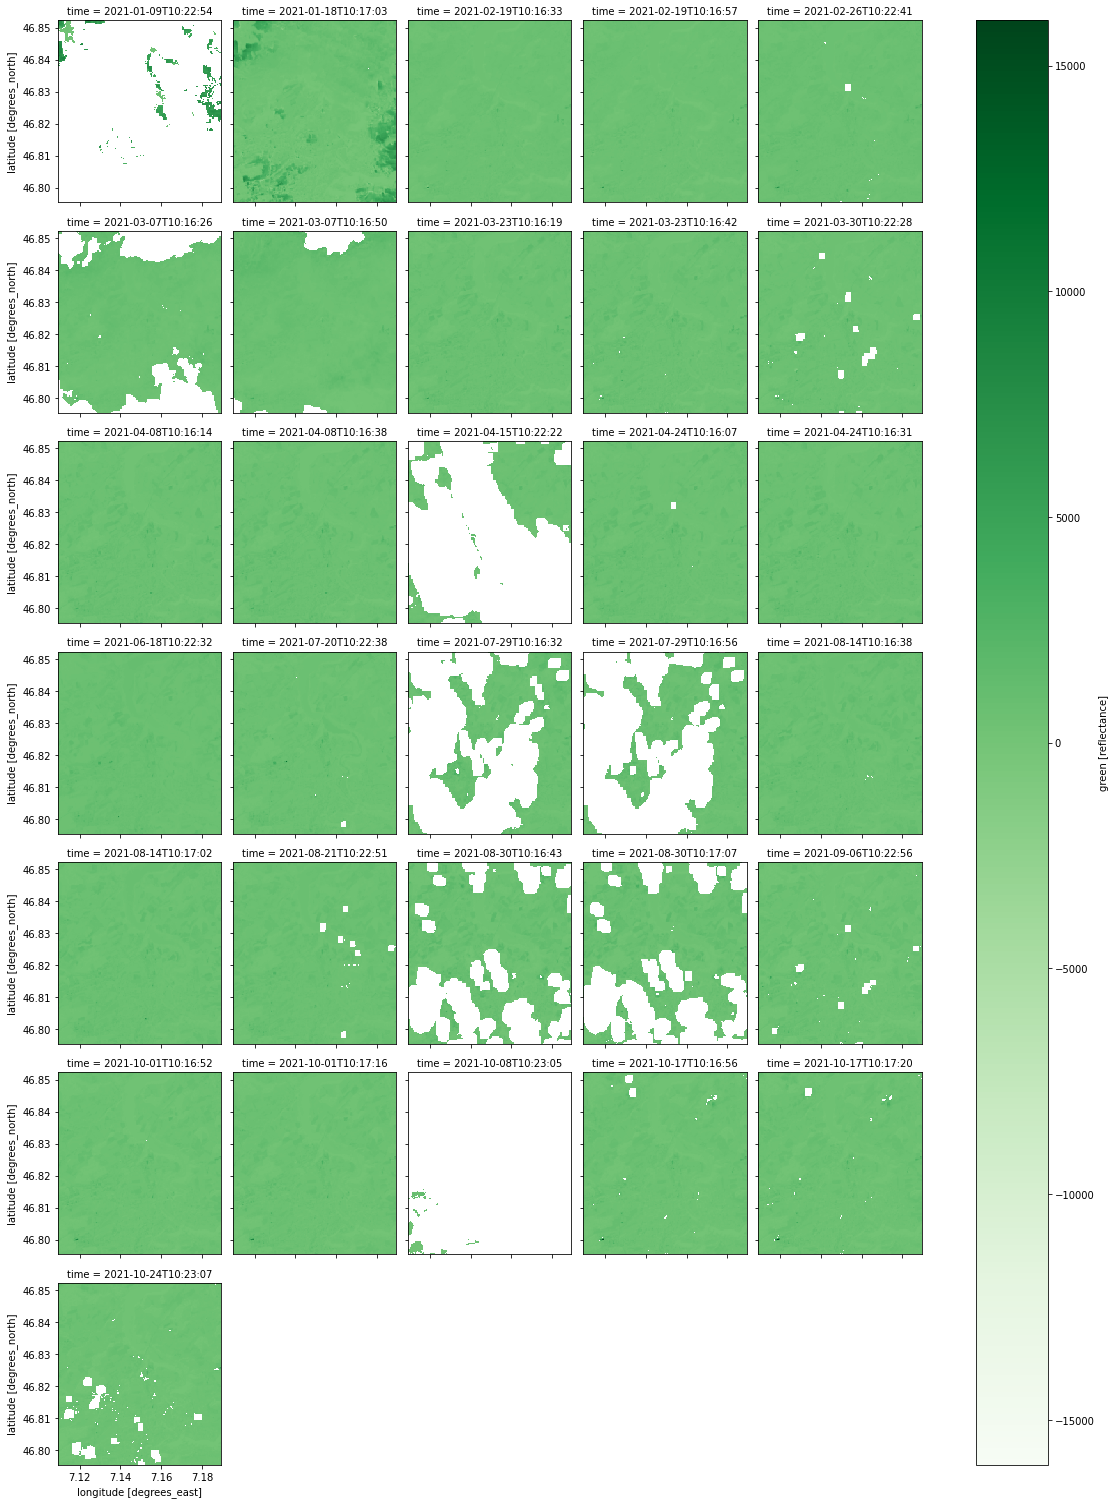

In [13]:
# Let's plot green band for all time

dataset_clean.green.plot(x='longitude', y='latitude', col='time', col_wrap=5, cmap='Greens')

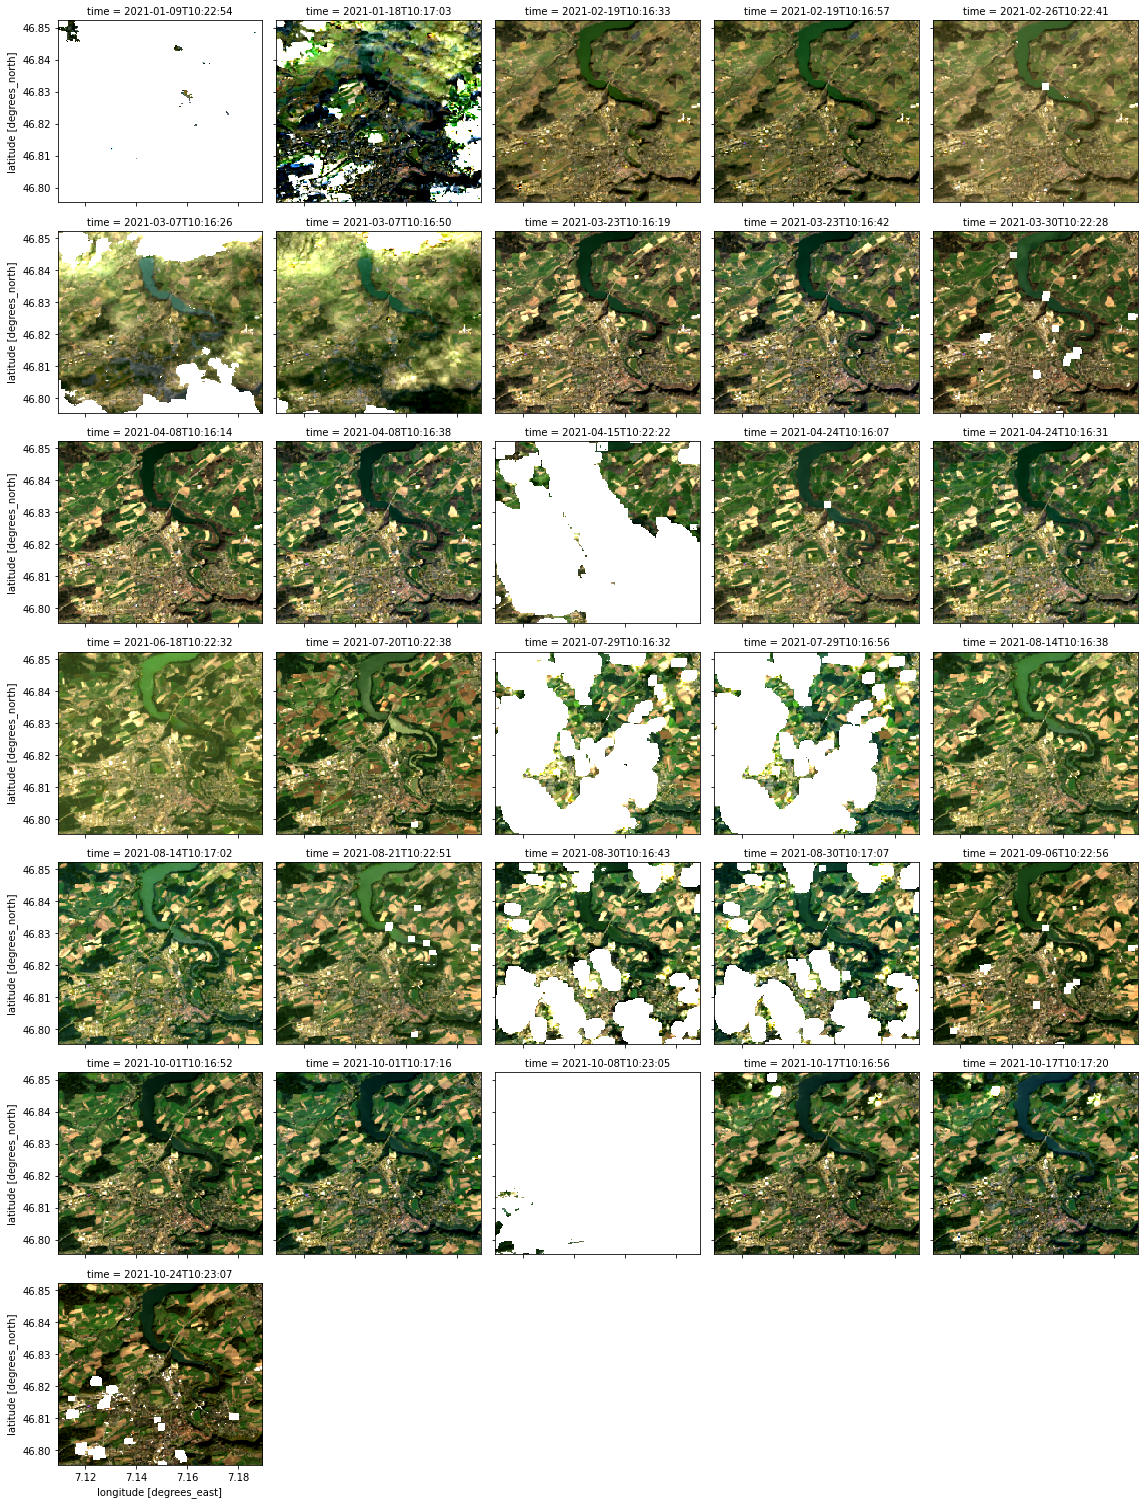

In [14]:
# Let's plot composites in True color (red, green, blue)
# robust=True guesses the minimum and maximum values for each image.
dataset_clean[['red','green','blue']].isel(time=time_list(dataset_clean)).to_array().plot.imshow(col='time',col_wrap=5, robust=True)

### Create, plot and export mosaic figure<a name="pngdef"></a>[<div style="text-align: right; font-size: 24px"> &#x1F51D; </div>](#top)
Across the whole geographical area, we can combine all our different satellite images into one composite/mosaic that represents the time period of interest.

In [15]:
# Create a mosaic
# several mosaic function (and options) are available:
# - create_mosaic(dataset_in, clean_mask)
# - create_mosaic(dataset_in.sortby('time', ascending = False)
# - create_mean_mosaic(dataset_in)
# - create_median_mosaic(dataset_in)
# - create_min_ndvi_mosaic(dataset_in, clean_mask)
# - create_max_ndvi_mosaic(dataset_in, clean_mask)
# - create_hdmedians_multiple_band_mosaic(dataset_in, clean_mask, operation='median')
# - create_hdmedians_multiple_band_mosaic(dataset_in, clean_mask, operation='medoid')

# we will apply the last one at it seems to be the best balance betwee visual result an processing time
mosaic = create_hdmedians_multiple_band_mosaic(dataset_clean, clean_mask, operation='medoid')
mosaic

<xarray.Dataset>
Dimensions:      (latitude: 167, longitude: 235)
Coordinates:
    spatial_ref  int32 4326
  * latitude     (latitude) float64 46.85 46.85 46.85 46.85 ... 46.8 46.8 46.8
  * longitude    (longitude) float64 7.109 7.11 7.11 7.11 ... 7.188 7.189 7.189
Data variables:
    blue         (latitude, longitude) float64 574.0 334.0 321.0 ... 482.0 532.0
    green        (latitude, longitude) float64 936.0 609.0 587.0 ... 700.0 732.0
    red          (latitude, longitude) float64 967.0 538.0 497.0 ... 560.0 657.0
    pixel_qa     (latitude, longitude) float64 322.0 322.0 322.0 ... 322.0 322.0
    nir          (latitude, longitude) float64 3.684e+03 4.06e+03 ... 3.371e+03
    swir1        (latitude, longitude) float64 2.247e+03 2.049e+03 ... 2.399e+03
    swir2        (latitude, longitude) float64 1.419e+03 986.0 ... 1.471e+03

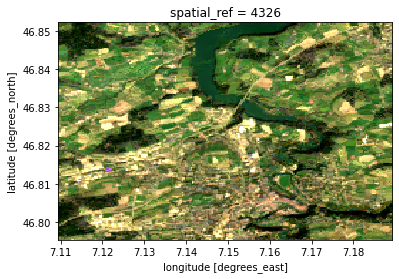

In [16]:
# Plot mosaic the default way
mosaic[['red','green','blue']].to_array().plot.imshow(x='longitude', y='latitude', robust=True)

Input file size is 235, 167
0...10...20...30...40...50...60...70...80...90...100 - done.


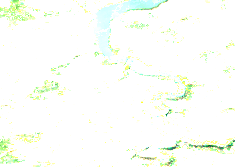

In [17]:
# Export mosaic as composite png the default way
write_png_from_xr('demo_mosaic.png', mosaic ,['red', 'green', 'blue'])

# png can be downloaded and visualized through the Home page of the Jupyter interface
# but it can also be visualized in the notebook
Image('demo_mosaic.png')

Text(0.5, 0, 'Value')

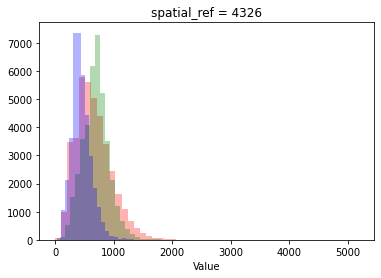

In [18]:
# You might find the image a bit lighter (or darker), then let's find dataset values distribution
kwargs = dict(bins = 50, alpha = 0.3)

mosaic.red.plot.hist(color='red', **kwargs)
mosaic.green.plot.hist(color='green', **kwargs, stacked = True)
mosaic.blue.plot.hist(color='blue', **kwargs, stacked = True)
plt.xlabel('Value')

Input file size is 235, 167
0...10...20...30...40...50...60...70...80...90...100 - done.


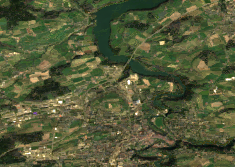

In [19]:
# improve rendering using scale option
# and display the png

write_png_from_xr('demo_mosaic_scaled.png', mosaic ,['red', 'green', 'blue'], scale = [(0,2000),(0,2000),(0,2000)])

Image('demo_mosaic_scaled.png')

### Plot and export mosaic figure the Swiss Data Cube way<a name="pngsdc"></a>

This adds bonus features such as a title, scale bar...

For documentation run a cell containing:

`composite_fig?`
[<div style="text-align: right; font-size: 24px"> &#x1F51D; </div>](#top)

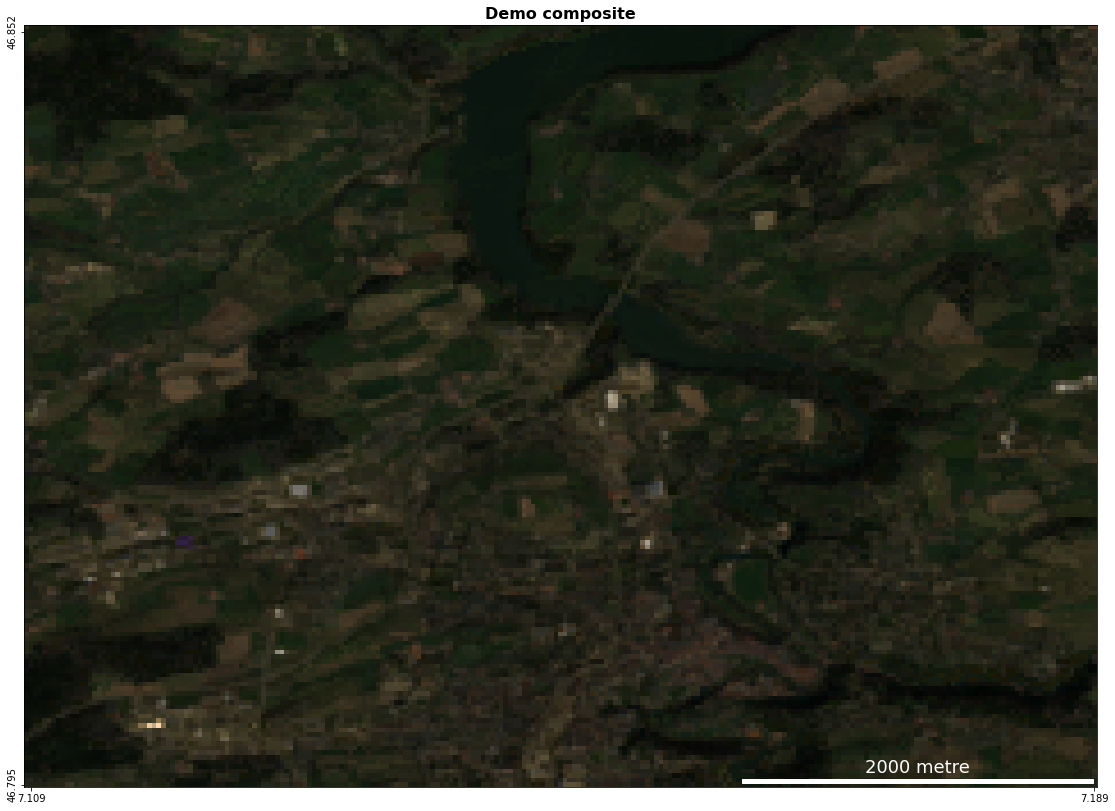

In [21]:
# Export previous mosaic as composite png the SDC way

composite_fig(mosaic,
              bands = ['red', 'green', 'blue'],
              title = 'Demo composite',
              scalebar_color = 'white',
              max_size = 16)

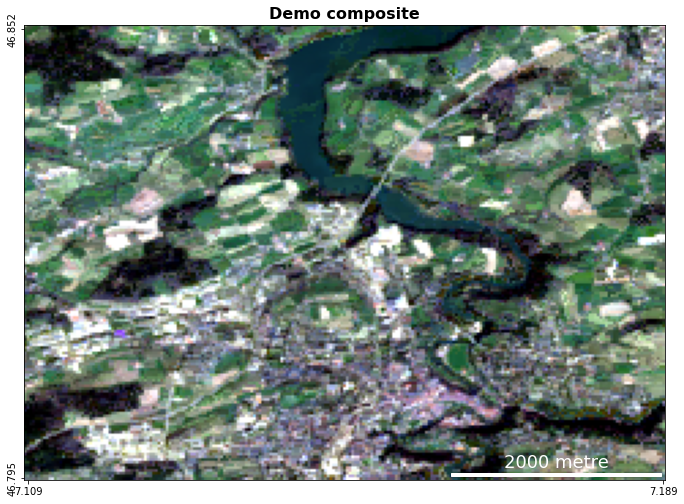

In [22]:
# for the demo let's reduce the figure size and stretch the image histogram

composite_fig(mosaic,
              bands = ['red', 'green', 'blue'],
              title = 'Demo composite',
              scalebar_color = 'white',
              max_size = 10,
              hist_str = 'contr')

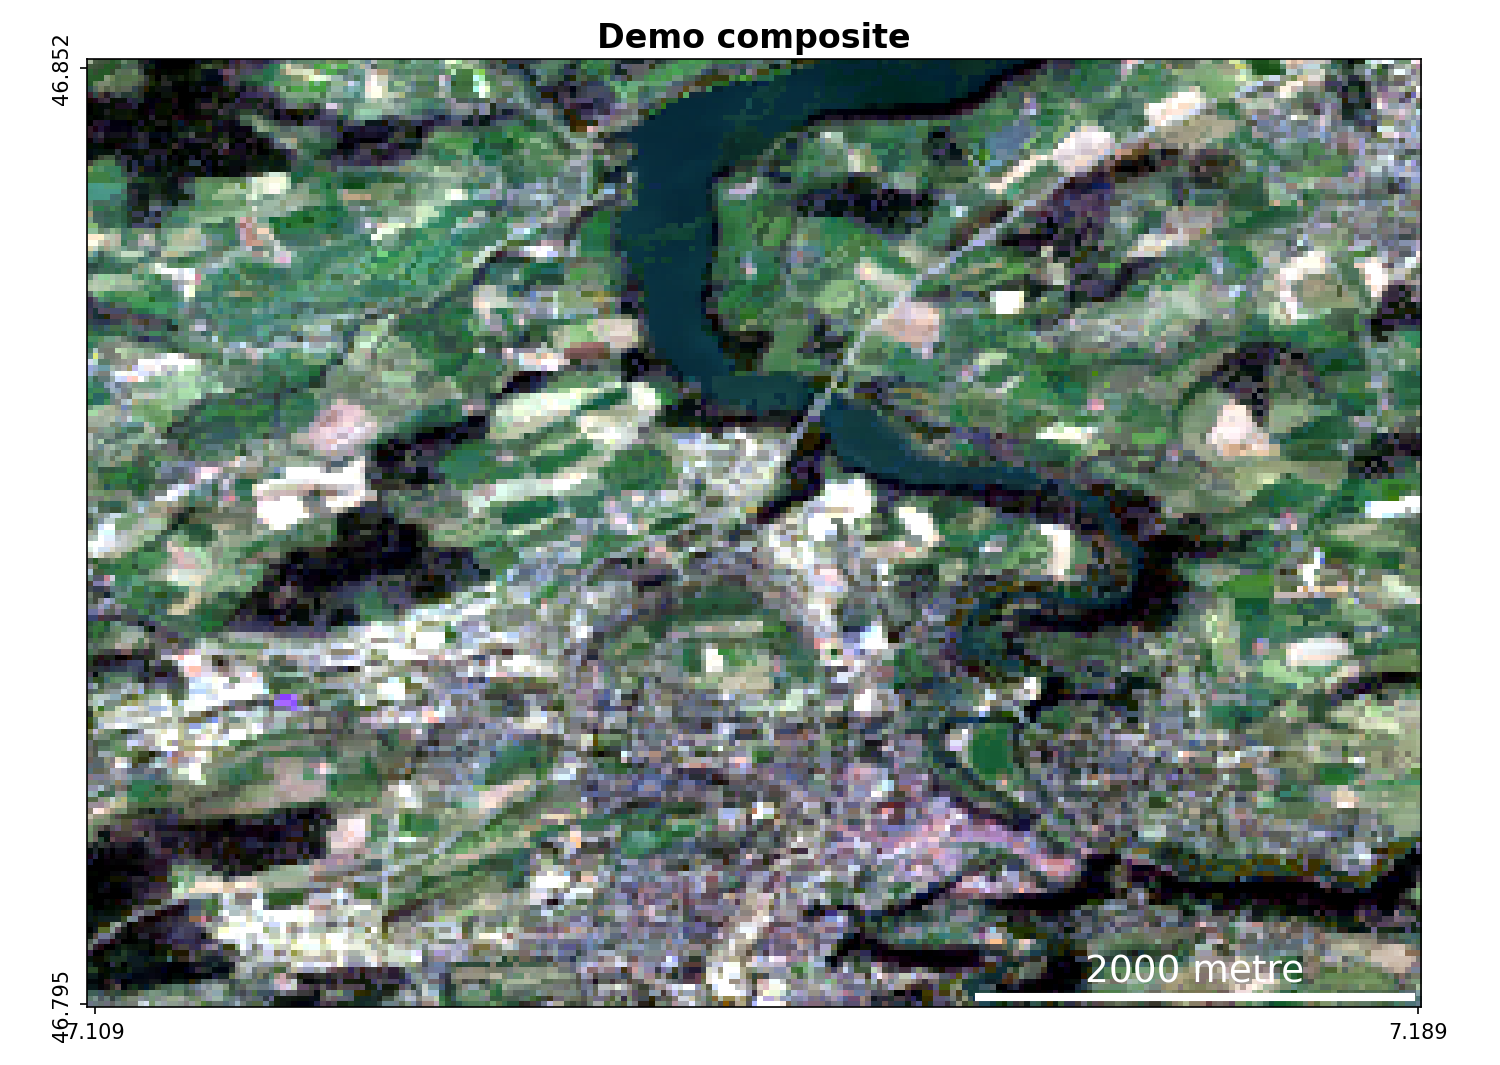

In [23]:
# to export the composite as png, simply add the fig_name parameter

composite_fig(mosaic,
              bands = ['red', 'green', 'blue'],
              title = 'Demo composite',
              scalebar_color = 'white',
              max_size = 10,
              hist_str = 'contr',
              fig_name = 'demo_composite.png')

# when a png is created the composite is not displayed, but it can be downloaded and visualized
# through the Home page of the Jupyter interface or added to the notebook with the command:
Image('demo_composite.png')

### Export xarray.Dataset <a name="exportds"></a>[<div style="text-align: right; font-size: 24px"> &#x1F51D; </div>](#top)

In [26]:
# Export mosaic (xarray.Dataset) as a multi-band (containing all bands) NetCDF
mosaic.to_netcdf('mosaic.nc')

# as NetCDF file is created the composite and can be downloaded through the Home page of the Jupyter
# interface. A direct link can also be added to the notebook with the command. But user might have to use
# Shift + Right click to save the link.
display(HTML("""<a href="mosaic.nc" target="_blank" >download NetCDF</a>"""))

In [27]:
# Export a GeoTIFF - can be added straight into software like QGIS/ArcGIS.

# For documentation run a cell containing: `write_geotiff_from_xr?`

# As the CRS information was lots during mosaic creation it has to be precised in the next function

write_geotiff_from_xr('mosaic.tif', mosaic, crs = dataset_clean.crs, compr = 'DEFLATE')

# add a direct link (user might have to use Shift + Right click to save the link).
display(HTML("""<a href="mosaic.tif" target="_blank" >download geotiff</a>"""))

### Computing Normalized Difference Indexes


In [51]:
# Let's start computing NDVI for each time

ndvi = (dataset_clean.nir - dataset_clean.red) / (dataset_clean.nir + dataset_clean.red)
ndvi

<xarray.DataArray (time: 31, latitude: 167, longitude: 235)>
array([[[-8.73761085e-03, -3.88852884e-04,  1.05428590e-02, ...,
                     nan,             nan,             nan],
        [ 1.11322114e-03,  1.05043387e-02,  9.71887026e-03, ...,
                     nan,             nan,             nan],
        [ 1.13585317e-02,  1.08350094e-02,  8.87064742e-03, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 1.61982095e-01,  1.82474332e-01,  2.07198250e-01, ...,
          5.24710831e-01,  4.43078144e-01,  3.79921958e-01],
        [ 1.82559662e-01,  1.88422576e-01,  1.97105644e-01, ...,
          3.85374150e-01,  3.87936943e-01,  4.59277289e-01],
        [ 1.78360101e-01,  1.92720307e-01,  2.09274673e-01, ...,
          3.06149511e-01,  3.46412352e-01,  4.21494371e-01],
...
        [ 8.43506196e-01,  8.43506196e-01,  8.33520810e-01, ...,
          7.41592920e-01,  7.41592920e-01,  6.88006271e-01],
        [ 7.54642656e-01,  6.66565809e-01,  6.56193572e-01, ...,
          8.20809249e-01,  8.20809249e-01,  8.35047306e-01],
        [ 6.18851252e-01,  5.41511772e-01,  6.43445218e-01, ...,
          8.37608849e-01,  8.37608849e-01,  8.02960222e-01]],

       [[ 3.06407531e-01,  2.10923881e-01,  1.64048866e-01, ...,
          6.96952435e-01,  2.33365790e-01,  1.89524466e-01],
        [ 1.84111337e-01,  1.70490851e-01,  1.75768427e-01, ...,
          3.44444444e-01,  2.76756247e-01,  2.15843347e-01],
        [ 1.74401845e-01,  1.74743025e-01,  1.79981911e-01, ...,
          2.25543478e-01,  2.74345550e-01,  4.60820138e-01],
        ...,
        [ 7.46967071e-01,  7.46967071e-01,  7.36559140e-01, ...,
          7.12289616e-01,  7.12289616e-01,  6.49003148e-01],
        [ 7.05715903e-01,  5.81528662e-01,  6.31724138e-01, ...,
          7.93204698e-01,  7.93204698e-01,  8.14273431e-01],
        [ 5.89826143e-01,  5.44520548e-01,  5.83710407e-01, ...,
          8.11466942e-01,  8.11466942e-01,  7.75253149e-01]]])
Coordinates:
  * time         (time) datetime64[ns] 2021-01-09T10:22:54 ... 2021-10-24T10:...
  * latitude     (latitude) float64 46.85 46.85 46.85 46.85 ... 46.8 46.8 46.8
  * longitude    (longitude) float64 7.109 7.11 7.11 7.11 ... 7.188 7.189 7.189
    spatial_ref  int32 4326

In [29]:
# then compute mean NDVI of the full time period
ndvi_mean = ndvi.mean(dim=['time'])

# replace +-Inf by nan
ndvi_mean = ndvi_mean.where(np.isfinite(ndvi_mean))
ndvi_mean

<xarray.DataArray (latitude: 167, longitude: 235)>
array([[0.52684579, 0.62232396, 0.65614763, ..., 0.62135528, 0.25140022,
        0.19205801],
       [0.64828106, 0.66087002, 0.66428159, ..., 0.27460469, 0.26849095,
        0.24766831],
       [0.66814857, 0.67210169, 0.67097591, ..., 0.2441447 , 0.30927377,
        0.4008828 ],
       ...,
       [0.67083651, 0.67083651, 0.67242241, ..., 0.68203533, 0.68203533,
        0.59602104],
       [0.5743525 , 0.53543256, 0.57065938, ..., 0.70164806, 0.70164806,
        0.69644303],
       [0.53067806, 0.56682051, 0.53349424, ..., 0.6991211 , 0.6991211 ,
        0.64249524]])
Coordinates:
  * latitude     (latitude) float64 46.85 46.85 46.85 46.85 ... 46.8 46.8 46.8
  * longitude    (longitude) float64 7.109 7.11 7.11 7.11 ... 7.188 7.189 7.189
    spatial_ref  int32 4326

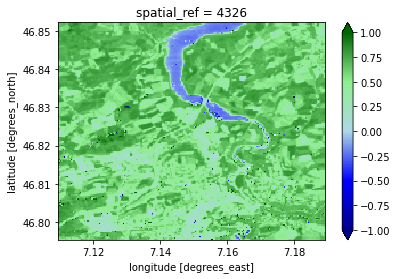

In [30]:
# plot ndvi_mean the default way (as in previous sections, but by using custom NDVI colors
# and fixed extreme colors/values)

ndvi_mean.plot.imshow(x='longitude', y='latitude', vmin=-1, vmax=1,
                      cmap = colors.LinearSegmentedColormap.from_list('ndvi', ['darkblue','blue','lightblue', \
                                                                               'lightgreen','darkgreen'], N=256))


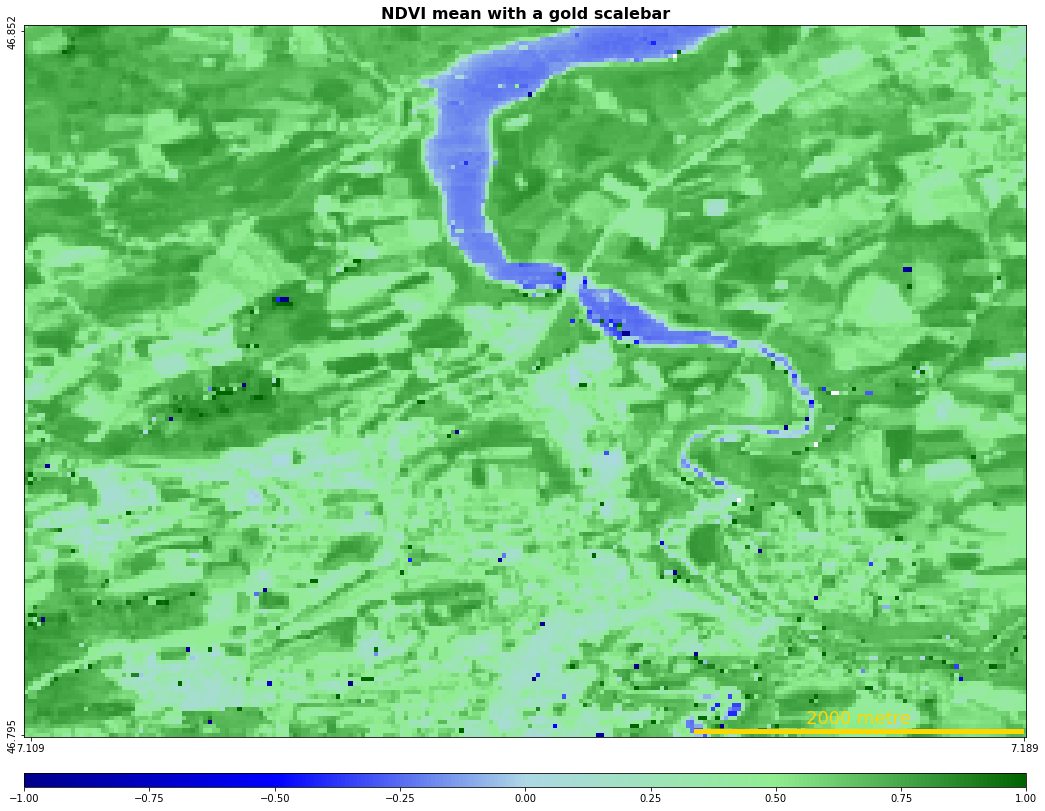

In [31]:
# equivalent plot the SDC way (oneband_fig function)

oneband_fig(ndvi_mean,
            leg = colors.LinearSegmentedColormap.from_list('ndvi', ['darkblue','blue','lightblue',
                                                                    'lightgreen','darkgreen'], N=256),
            title = 'NDVI mean with a gold scalebar',
            scalebar_color = 'gold',
            max_size = 16,
            v_min = -1,
            v_max = 1)

# Compare the figure width/height ratio for default output and the Swiss Data Cube option.
# Notice how the x and y resolution differ in the above figure.

### Export a DataArray 

In [33]:
# Export as NetCDF

ndvi_mean.to_netcdf('ndvi_mean.nc')
display(HTML("""<a href="ndvi_mean.nc" target="_blank" >download NetCDF</a>"""))

In [34]:
# Export as geotiff
# xarray.DataArray need to be converted to xarray.Dataset and the CRS to be defined

write_geotiff_from_xr('ndvi_mean.tif', ndvi_mean.to_dataset(name = 'NDVI'), ['NDVI'],
                      crs = dataset_clean.crs, compr = 'DEFLATE')
display(HTML("""<a href="ndvi_mean.tif" target="_blank" >download geotiff</a>"""))

In [49]:
# compute NDWI and NDBI by combining the 2 commands (then we do not need to delete intermediate index)

ndwi_mean = ((dataset_clean.green - dataset_clean.nir) / (dataset_clean.green + dataset_clean.nir)).mean(dim=['time'])
ndwi_mean = ndwi_mean.where(np.isfinite(ndwi_mean)) # replace +-Inf by nan
ndbi_mean = ((dataset_clean.swir2 - dataset_clean.nir) / (dataset_clean.swir2 + dataset_clean.nir)).mean(dim=['time'])
ndbi_mean = ndbi_mean.where(np.isfinite(ndbi_mean)) # replace +-Inf by nan

In [50]:
# for fun let's create a false color composite using Built, Vegetation and Water indexes

# create a dataset with the 3 bands
bvw_ds = ndbi_mean.to_dataset(name = 'ndbi').merge(ndvi_mean.to_dataset(name = 'ndvi')).merge(ndwi_mean.to_dataset(name = 'ndwi'))
# delete the variable we do not need anymore
del ndbi_mean
del ndvi_mean
del ndwi_mean
# fix nan issues
bvw_ds = bvw_ds.fillna(bvw_ds.min())
bvw_ds

NameError: name 'ndvi_mean' is not defined

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        6.0000e+00, 1.2000e+01, 4.8000e+02, 3.4868e+04, 2.3540e+03,
        1.4530e+03, 4.1000e+01, 1.3000e+01, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-8.32214051, -7.90071148, -7.47928245, -7.05785342, -6.63642439,
        -6.21499536, -5.79356632, -5.37213729, -4.95070826, -4.52927923,
        -4.1078502 , -3.68642117, -3.26499214, -2.84356311, -2.42213407,
        -2.00070504, -1.57927601, -1.15784698, -0.73641795, -0.31498892,
         0.10644011,  0.52

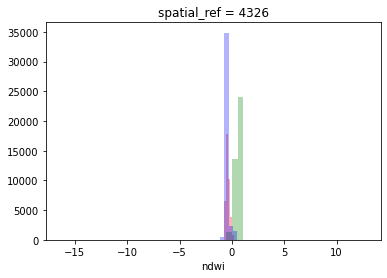

In [37]:
bvw_ds.ndbi.plot.hist(bins = 50, color='red', alpha = 0.3)
bvw_ds.ndvi.plot.hist(bins = 50, color='green', alpha = 0.3, stacked = True)
bvw_ds.ndwi.plot.hist(bins = 50, color='blue', alpha = 0.3, stacked = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


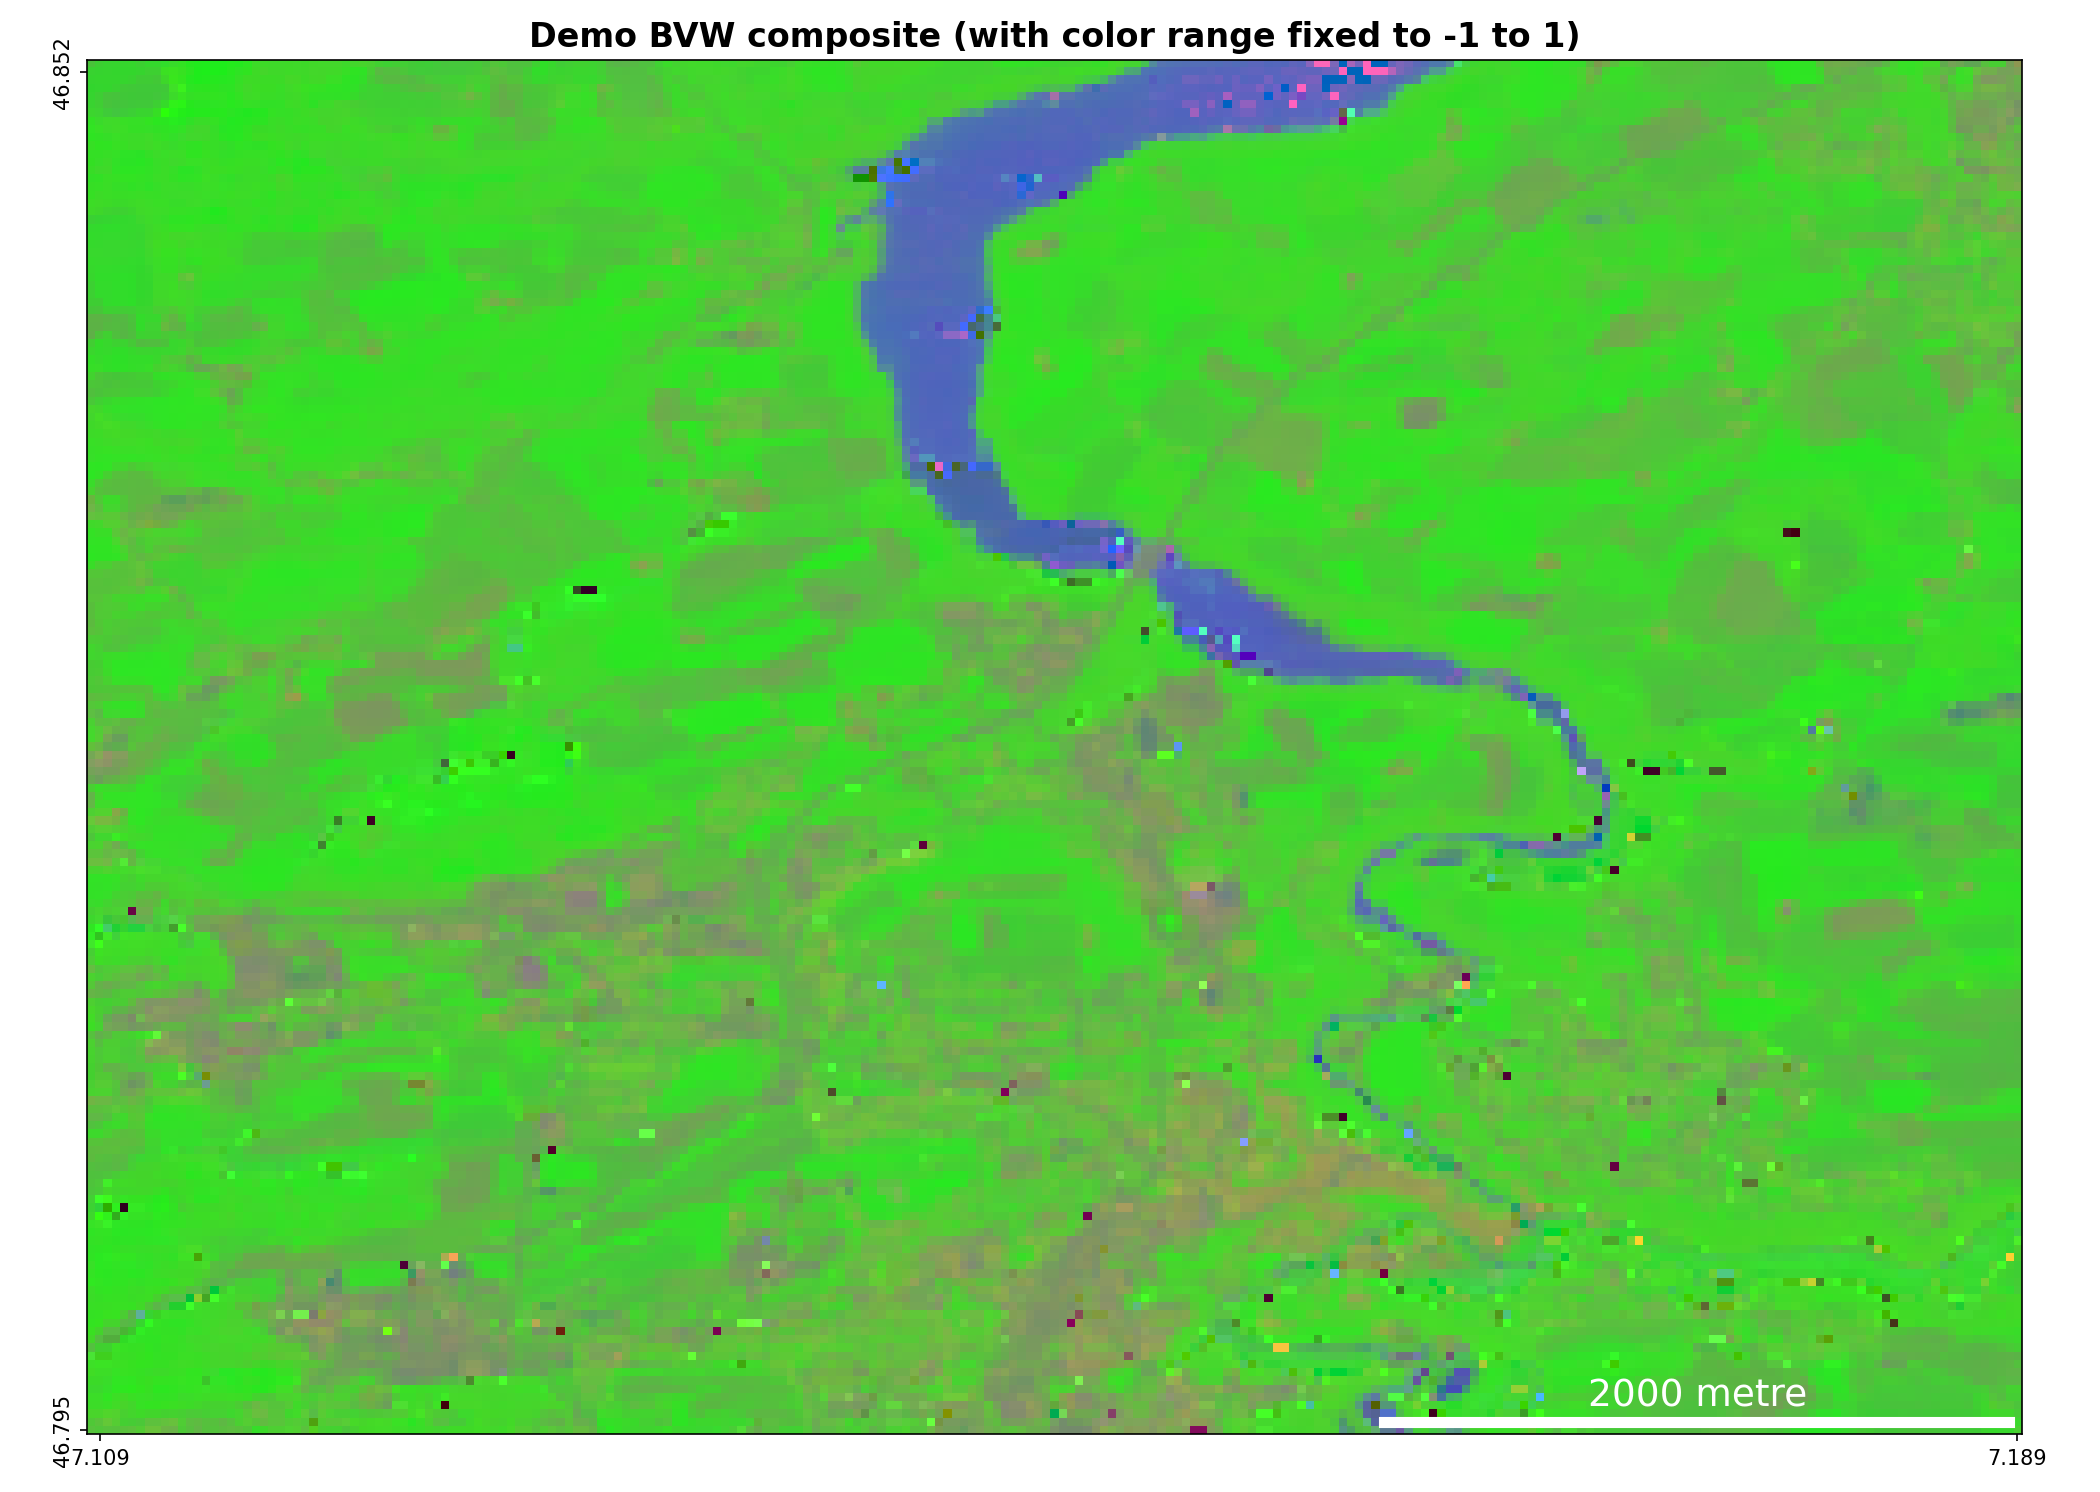

In [38]:
# finally create a figure with fixed display range (-1 to +1 as we are dealing with normalized indexes)
composite_fig(bvw_ds,
              bands = ['ndbi', 'ndvi', 'ndwi'],
              title = 'Demo BVW composite (with color range fixed to -1 to 1)',
              scalebar_color = 'white',
              max_size = 14,
              v_min = -1,
              v_max = 1,
              fig_name = 'demo_BVW_composite.png')

# and diplay it
Image('demo_BVW_composite.png')

### Single time water time series analysis <a name="waterts"></a>

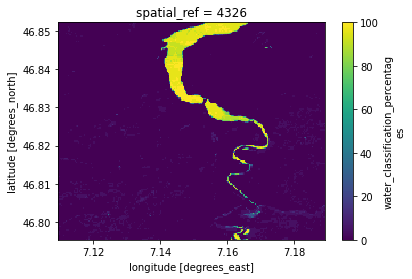

In [39]:
# run the "Water Observation From Space" algorithm
# replace nodata values (-9999) by nan
# compute percentage of time a pixel was detected as water

# by default this function displays several warnings, we are turning them off...
import warnings
warnings.filterwarnings("ignore")

ts_water_classification = wofs_classify(dataset_clean, clean_mask = clean_mask)
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999)
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

# display water percentage
water_classification_percentages.plot()

(array([3.7048e+04, 1.9600e+02, 6.6000e+01, 3.9000e+01, 3.5000e+01,
        3.4000e+01, 3.3000e+01, 1.6000e+01, 1.9000e+01, 1.4000e+01,
        2.7000e+01, 1.9000e+01, 1.3000e+01, 2.7000e+01, 1.8000e+01,
        2.7000e+01, 6.5000e+01, 1.4200e+02, 2.5500e+02, 1.1520e+03]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

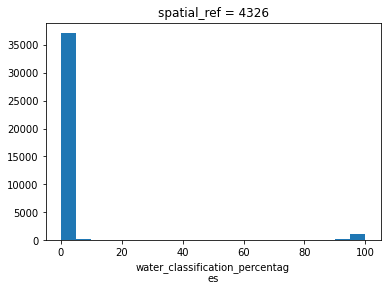

In [40]:
# display values distribution

water_classification_percentages.plot.hist(bins = 20)

### Exploring time series

In [102]:
from shapely.geometry import Polygon

from swiss_utils.data_cube_utilities.sdc_utilities import new_get_query_metadata
from swiss_utils.data_cube_utilities.sdc_advutils import draw_map

mtd = new_get_query_metadata(dc, product)
# if too slow use the line below (will not be accurate with all product
# mtd = new_get_query_metadata(dc, product_sel.value, quick = True)

full_lat = mtd['lat_extents']
full_lon = mtd['lon_extents']
min_max_dates = mtd['time_extents']
crs = mtd['crs']

# Add an empty map you can draw on it
m, drawn_features = draw_map([min_lat, max_lat], [min_lon, max_lon], 'epsg:4326')
print('Zoom, pan and then draw a marker where you want to extract a time series:')
m

Zoom, pan and then draw a marker where you want to extract a time series:


Map(center=[46.8236665, 7.149353], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [103]:
coords = drawn_features.last_draw['geometry']['coordinates']

In [104]:
coords

[7.138023, 46.827949]

Text(0, 0.5, 'NDWI')

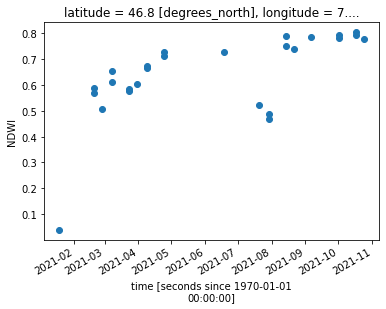

In [105]:
ndvi.sel(latitude=coords[0], longitude=coords[1], method='nearest').plot(marker='o', linestyle='none')
plt.ylabel('NDWI')

Text(0, 0.5, 'NDWI')

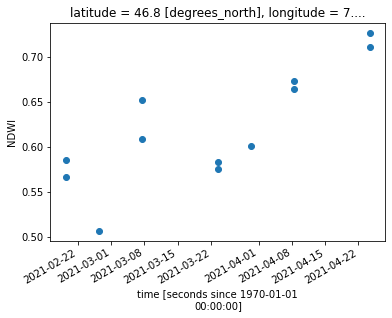

In [106]:
# Let's look at a certain time period in more detail
ndvi.sel(latitude=coords[0], longitude=coords[1], method='nearest').sel(time=slice('2021-02-01', '2021-04-25')).plot(marker='o', linestyle='none')
plt.ylabel('NDWI')

In [107]:
# We can convert our time series to a Pandas series for more examination
ndvi_at_point = ndvi.sel(latitude=coords[0], longitude=coords[1], method='nearest').to_pandas()

In [108]:
ndvi_at_point

time
2021-01-09 10:22:54         NaN
2021-01-18 10:17:03    0.040259
2021-02-19 10:16:33    0.567337
2021-02-19 10:16:57    0.585391
2021-02-26 10:22:41    0.507038
2021-03-07 10:16:26    0.652238
2021-03-07 10:16:50    0.609150
2021-03-23 10:16:19    0.575895
2021-03-23 10:16:42    0.584044
2021-03-30 10:22:28    0.601681
2021-04-08 10:16:14    0.664419
2021-04-08 10:16:38    0.673784
2021-04-15 10:22:22         NaN
2021-04-24 10:16:07    0.711468
2021-04-24 10:16:31    0.727190
2021-06-18 10:22:32    0.726391
2021-07-20 10:22:38    0.522217
2021-07-29 10:16:32    0.468148
2021-07-29 10:16:56    0.487313
2021-08-14 10:16:38    0.750118
2021-08-14 10:17:02    0.787577
2021-08-21 10:22:51    0.736300
2021-08-30 10:16:43         NaN
2021-08-30 10:17:07         NaN
2021-09-06 10:22:56    0.783253
2021-10-01 10:16:52    0.782093
2021-10-01 10:17:16    0.790675
2021-10-08 10:23:05         NaN
2021-10-17 10:16:56    0.792683
2021-10-17 10:17:20    0.802960
2021-10-24 10:23:07    0.775253
dty

<AxesSubplot:xlabel='time'>

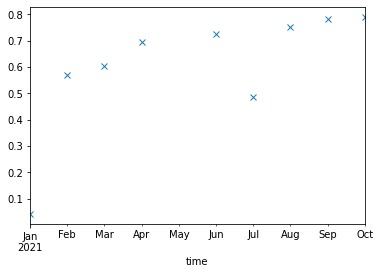

In [109]:
# Let's resample to a monthly data series. Monthly values are calculated as the median of all values in the month.
ndvi_pt_monthly = ndvi_at_point.resample('1M').median()
ndvi_pt_monthly.plot(marker='x', linestyle='none')

In [79]:
# And now let's export to Comma Separated Format, CSV - this can be opened by other programs like Excel.
ndvi_pt_monthly.to_csv('ndvi_at_pt.csv')